# Imports e Configurações

In [1]:
%pip install pandas numpy seaborn matplotlib mlflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os
import mlflow
import mlflow.sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from mlflow.models.signature import infer_signature


# Configurações visuais
sns.set_style("whitegrid")

TRAIN_INPUT_FILE_PATH = '../data/test.csv' 
TEST_INPUT_FILE_PATH = '../data/test.csv' 

# Caminho de saída para o dataset amostrado
OUTPUT_PATH_TRAIN = '../data/generated/train_chunk.csv'
OUTPUT_PATH_TEST = '../data/generated/test_chunk.csv'

# Tamanho da amostra desejada (balanceada)
SAMPLES_PER_CLASS_TRAIN = 50 * 1000 
SAMPLES_PER_CLASS_TEST = 5 * 1000
RANDOM_SEED = 99

SKIP_TUNNING = False
CACHED_TUNNING_PARAMS = {}

print("Ambiente configurado.")

Ambiente configurado.


# Limpeza dos dados

In [3]:
import pandas as pd
import numpy as np

def _extract_stratified_balanced(file_path, samples_needed_per_class):
    """
    Lê o arquivo e extrai amostras balanceadas por Classe E por Tamanho do texto.
    Estratégia: 3 Bins (Curto, Médio, Longo).
    Meta: 1/3 das amostras para cada bin dentro de cada classe.
    """
    print(f"--> Processando arquivo com estratificação: {file_path}")
    
    # Definição dos Bins (Limites de caracteres)
    # Ajuste conforme a realidade do seus dados
    BIN_SHORT = 150
    BIN_MEDIUM = 600
    
    # Meta de amostras por sub-grupo (ex: Positivo-Curto, Positivo-Médio...)
    # Dividimos a meta da classe por 3
    quota_per_subgroup = samples_needed_per_class // 3
    
    # Dicionário para armazenar os dados separadamente
    # Estrutura: data_store[classe][bin]
    data_store = {
        1: {'short': [], 'medium': [], 'long': []}, # Classe 1 (Negativo no Raw)
        2: {'short': [], 'medium': [], 'long': []}  # Classe 2 (Positivo no Raw)
    }
    
    chunk_size = 100000
    chunks_processed = 0
    
    try:
        # Lendo em chunks
        for chunk in pd.read_csv(file_path, chunksize=chunk_size, header=None, names=['polarity', 'title', 'text']):    
            chunks_processed += 1
            print(f"   Lendo chunk {chunks_processed}...", end='\r')

            # 1. Limpeza Básica
            chunk = chunk.dropna(subset=["text", "polarity"])
            chunk['text'] = chunk['text'].astype(str)
            chunk['title'] = chunk['title'].fillna("").astype(str)
            chunk['polarity'] = chunk['polarity'].astype(int)
            
            # 2. Calcular tamanho e enriquecer texto (Título + Texto)
            # O tamanho é calculado sobre o texto que será usado no treino
            chunk['full_text'] = chunk['title'] + " " + chunk['text']
            chunk['char_len'] = chunk['full_text'].str.len()
            
            # 3. Iterar sobre as classes (1 e 2)
            for sentiment in [1, 2]:
                # Filtra pelo sentimento atual
                df_sent = chunk[chunk['polarity'] == sentiment]
                
                if df_sent.empty: continue

                # --- Bin Curto ---
                if len(data_store[sentiment]['short']) < quota_per_subgroup:
                    needed = quota_per_subgroup - len(data_store[sentiment]['short'])
                    subset = df_sent[df_sent['char_len'] < BIN_SHORT]
                    data_store[sentiment]['short'].extend(subset[['full_text', 'polarity']].head(needed).values.tolist())
                
                # --- Bin Médio ---
                if len(data_store[sentiment]['medium']) < quota_per_subgroup:
                    needed = quota_per_subgroup - len(data_store[sentiment]['medium'])
                    subset = df_sent[(df_sent['char_len'] >= BIN_SHORT) & (df_sent['char_len'] < BIN_MEDIUM)]
                    data_store[sentiment]['medium'].extend(subset[['full_text', 'polarity']].head(needed).values.tolist())
                    
                # --- Bin Longo ---
                if len(data_store[sentiment]['long']) < quota_per_subgroup:
                    needed = quota_per_subgroup - len(data_store[sentiment]['long'])
                    subset = df_sent[df_sent['char_len'] >= BIN_MEDIUM]
                    data_store[sentiment]['long'].extend(subset[['full_text', 'polarity']].head(needed).values.tolist())

            # Critério de Parada: Verificamos se TODOS os baldes estão cheios
            full_buckets = 0
            total_buckets = 6 # 2 classes * 3 bins
            for s in [1, 2]:
                for b in ['short', 'medium', 'long']:
                    if len(data_store[s][b]) >= quota_per_subgroup:
                        full_buckets += 1
            
            if full_buckets == total_buckets:
                print(f"\nTodos os bins de tamanho foram preenchidos no chunk {chunks_processed}!")
                break
        
        # 4. Consolidação
        final_rows = []
        for s in [1, 2]:
            # Mapeia label: 1(Neg) -> 0, 2(Pos) -> 1
            mapped_label = 0 if s == 1 else 1
            for b in ['short', 'medium', 'long']:
                # Adiciona ao resultado final ajustando o label
                for text, _ in data_store[s][b]:
                    final_rows.append([text, mapped_label])
        
        df_result = pd.DataFrame(final_rows, columns=['review_text', 'sentiment'])
        
        # Embaralha final
        df_result = df_result.sample(frac=1, random_state=42).reset_index(drop=True)
        
        return df_result

    except FileNotFoundError:
        print(f"\nERRO: Arquivo {file_path} não encontrado.")
        return pd.DataFrame()

# --- Função Wrapper (Mantida igual, apenas chamando a nova função interna) ---
def create_balanced_datasets(train_path, test_path, out_train, out_test, n_train, n_test):
    print("Iniciando amostragem ESTRATIFICADA de TREINO...")
    df_train = _extract_stratified_balanced(train_path, n_train)
    if not df_train.empty:
        df_train.to_csv(out_train, index=False)
        print(f"Treino salvo: {out_train} | Shape: {df_train.shape}")
    
    print("\nIniciando amostragem ESTRATIFICADA de TESTE...")
    df_test = _extract_stratified_balanced(test_path, n_test)
    if not df_test.empty:
        df_test.to_csv(out_test, index=False)
        print(f"Teste salvo: {out_test} | Shape: {df_test.shape}")
        
    return df_train, df_test

# Execução (Descomente para rodar se tiver os arquivos)
df_train, df_test = create_balanced_datasets(TRAIN_INPUT_FILE_PATH, TEST_INPUT_FILE_PATH, OUTPUT_PATH_TRAIN, OUTPUT_PATH_TEST, SAMPLES_PER_CLASS_TRAIN, SAMPLES_PER_CLASS_TEST)


Iniciando amostragem ESTRATIFICADA de TREINO...
--> Processando arquivo com estratificação: ../data/test.csv
Treino salvo: ../data/generated/train_chunk.csv | Shape: (97427, 2)

Iniciando amostragem ESTRATIFICADA de TESTE...
--> Processando arquivo com estratificação: ../data/test.csv
   Lendo chunk 1...
Todos os bins de tamanho foram preenchidos no chunk 1!
Teste salvo: ../data/generated/test_chunk.csv | Shape: (9996, 2)


# Análise Exploratória (EDA)

Gerando gráficos...


/var/folders/mx/th5bgtcn19d079t50rlghdrw0000gp/T/ipykernel_16998/3106201659.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='coolwarm', ax=ax1)
/var/folders/mx/th5bgtcn19d079t50rlghdrw0000gp/T/ipykernel_16998/3106201659.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sentiment', y='char_length', data=df, palette='coolwarm', showfliers=False, ax=ax3)


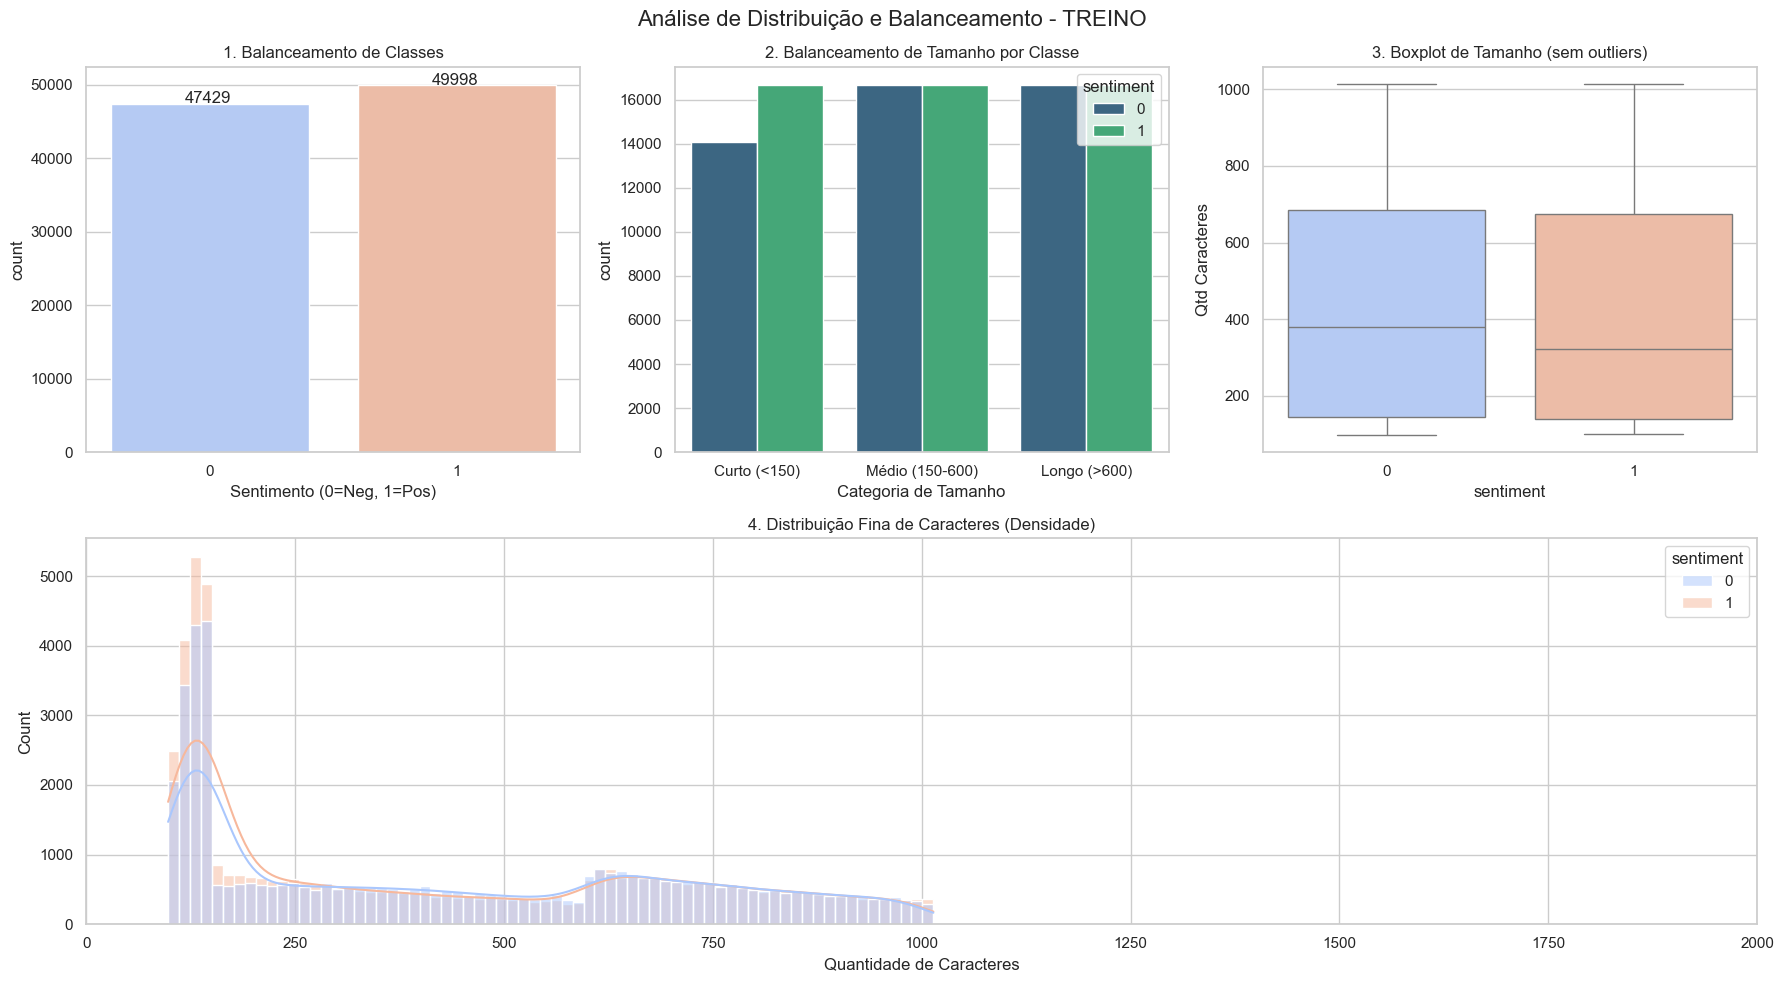


=== Estatísticas Descritivas: TREINO ===
length_category  Curto (<150)  Longo (>600)  Médio (150-600)
sentiment                                                   
0                       14097         16666            16666
1                       16666         16666            16666

Resumo de palavras:
             count       mean        std  min   25%   50%    75%    max
sentiment                                                              
0          47429.0  79.221868  51.312974  6.0  27.0  70.0  124.0  210.0
1          49998.0  75.190428  51.729310  8.0  26.0  59.0  122.0  218.0


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Configurações visuais
sns.set_theme(style="whitegrid")

# Supondo que df_train já esteja carregado do passo anterior

def analyze_distribution(df, title_suffix=""):
    if df.empty:
        print(f"Dataset {title_suffix} vazio.")
        return

    # --- Feature Engineering para Análise ---
    # Calcula contagens
    df['char_length'] = df['review_text'].astype(str).apply(len)
    df['word_count'] = df['review_text'].astype(str).apply(lambda x: len(x.split()))
    
    # Cria categorias para visualização (Bucketing)
    def categorize_len(length):
        if length < 150: return 'Curto (<150)'
        elif length < 600: return 'Médio (150-600)'
        else: return 'Longo (>600)'
    
    df['length_category'] = df['char_length'].apply(categorize_len)
    
    # Ordenar categorias para o gráfico ficar bonito
    category_order = ['Curto (<150)', 'Médio (150-600)', 'Longo (>600)']

    # --- PLOTAGEM ---
    fig = plt.figure(figsize=(18, 10))
    fig.suptitle(f'Análise de Distribuição e Balanceamento - {title_suffix}', fontsize=16)

    # 1. Distribuição de Sentimento (O clássico)
    ax1 = plt.subplot(2, 3, 1)
    sns.countplot(x='sentiment', data=df, palette='coolwarm', ax=ax1)
    ax1.set_title('1. Balanceamento de Classes')
    ax1.set_xlabel('Sentimento (0=Neg, 1=Pos)')
    for p in ax1.patches:
        ax1.annotate(f'{int(p.get_height())}', (p.get_x()+0.3, p.get_height()+50))

    # 2. Distribuição de Tamanho por Categoria (A PROVA do balanceamento novo)
    ax2 = plt.subplot(2, 3, 2)
    sns.countplot(x='length_category', hue='sentiment', data=df, order=category_order, palette='viridis', ax=ax2)
    ax2.set_title('2. Balanceamento de Tamanho por Classe')
    ax2.set_xlabel('Categoria de Tamanho')
    
    # 3. Boxplot de Caracteres (Para ver outliers e medianas)
    ax3 = plt.subplot(2, 3, 3)
    sns.boxplot(x='sentiment', y='char_length', data=df, palette='coolwarm', showfliers=False, ax=ax3)
    ax3.set_title('3. Boxplot de Tamanho (sem outliers)')
    ax3.set_ylabel('Qtd Caracteres')

    # 4. Histograma Detalhado (KDE)
    ax4 = plt.subplot(2, 1, 2) # Ocupa a parte de baixo toda
    sns.histplot(data=df, x='char_length', hue='sentiment', kde=True, bins=70, palette='coolwarm', alpha=0.5, ax=ax4)
    ax4.set_title('4. Distribuição Fina de Caracteres (Densidade)')
    ax4.set_xlim(0, 2000) # Focando na maioria dos dados
    ax4.set_xlabel('Quantidade de Caracteres')

    plt.tight_layout()
    plt.show()

    # --- Estatísticas Numéricas ---
    print(f"\n=== Estatísticas Descritivas: {title_suffix} ===")
    print(df.groupby(['sentiment', 'length_category'])['char_length'].count().unstack().fillna(0))
    print("\nResumo de palavras:")
    print(df.groupby('sentiment')['word_count'].describe())

# Executar Análise
print("Gerando gráficos...")
analyze_distribution(df_train, "TREINO")
# analyze_distribution(df_test, "TESTE") # Descomente para ver o teste

# Configurando ambiente de treino

In [5]:
mlflow.set_tracking_uri("http://0.0.0.0:5001") 
mlflow.set_experiment("TCC MLOps")
mlflow.sklearn.autolog()

print("MLflow configurado.")

KeyboardInterrupt: 

# Carregando dados processados

In [15]:
def load_dataset(path):
    try:
        df = pd.read_csv(path)

        df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

        # Combina título + texto
        for split in [df_train, df_test]:
            split['combined_text'] = (
                split['title'].astype(str) + " " + split['text'].astype(str)
            )

        X_train = df_train['combined_text']
        y_train = df_train['polarity']
        X_test = df_test['combined_text']
        y_test = df_test['polarity']

        print(f"Dados carregados. Treino: {len(X_train)} | Teste: {len(X_test)}")
        return X_train, y_train, X_test, y_test

    except FileNotFoundError:
        print("ERRO: Arquivo CSV não encontrado. Rode o pré-processamento primeiro.")

X_train, y_train, X_test, y_test = load_dataset(OUTPUT_PATH_TRAIN)

    
X_eval, y_eval, _, _ = load_dataset(OUTPUT_PATH_TEST)


Dados carregados. Treino: 319980 | Teste: 79996
Dados carregados. Treino: 40000 | Teste: 10000


# Loop de Experimentação

## Traning and select the best model

In [16]:
models_to_test = {
    "Naive_Bayes_Baseline": MultinomialNB(),
    "Logistic_Regression": LogisticRegression(max_iter=1000),
    "Linear_SVM": LinearSVC(),
    "Random_Forest": RandomForestClassifier(n_estimators=100, max_depth=10)
}

best_score = 0
best_name = None
best_pipe = None

for name, model in models_to_test.items():
    pipe = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
        ('classifier', model)
    ])

    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    score = f1_score(y_test, pred)

    print(f"[BASE] {name} → F1={score:.4f}")

    if score > best_score:
        best_score = score
        best_name = name
        best_pipe = pipe


2025/11/20 22:59:57 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e886925835154331ac2a4621a0dc5a3f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/11/20 22:59:57 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.
2025/11/20 23:00:28 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.


🏃 View run honorable-rook-356 at: http://0.0.0.0:5001/#/experiments/1/runs/e886925835154331ac2a4621a0dc5a3f
🧪 View experiment at: http://0.0.0.0:5001/#/experiments/1


2025/11/20 23:02:13 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.
2025/11/20 23:02:13 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'dacce63ccf2a478b9802f58ca9f48cb3', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/11/20 23:02:13 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.


[BASE] Naive_Bayes_Baseline → F1=0.8688


2025/11/20 23:02:45 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.


🏃 View run judicious-midge-257 at: http://0.0.0.0:5001/#/experiments/1/runs/dacce63ccf2a478b9802f58ca9f48cb3
🧪 View experiment at: http://0.0.0.0:5001/#/experiments/1


2025/11/20 23:04:31 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.
2025/11/20 23:04:31 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'cb11f918a866469b9463278d7fead9bd', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/11/20 23:04:31 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.


[BASE] Logistic_Regression → F1=0.9088


2025/11/20 23:05:12 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.


🏃 View run hilarious-bee-346 at: http://0.0.0.0:5001/#/experiments/1/runs/cb11f918a866469b9463278d7fead9bd
🧪 View experiment at: http://0.0.0.0:5001/#/experiments/1


KeyboardInterrupt: 

In [ ]:
tuning_strategy_map = {
    "Linear_SVM": {
        "model": LinearSVC(dual='auto', max_iter=2000),
        "param_grid": {
            "classifier__C": [0.1, 1, 10],
            "tfidf__max_features": [5000, 10000],
            "tfidf__ngram_range": [(1, 1), (1, 2)]
        }
    },
    "Logistic_Regression": {
        "model": LogisticRegression(max_iter=2000),
        "param_grid": {
            "classifier__C": [0.1, 1, 10],
            "tfidf__max_features": [5000, 10000]
        }
    },
    "Random_Forest": {
        "model": RandomForestClassifier(),
        "param_grid": {
            "classifier__n_estimators": [50, 100],
            "classifier__max_depth": [10, 20],
            "tfidf__max_features": [5000]
        }
    },
    "Naive_Bayes_Baseline": {  # <<< CORRIGIDO NOME
        "model": MultinomialNB(),
        "param_grid": {
            "classifier__alpha": [0.1, 0.5, 1.0],
            "tfidf__max_features": [5000, 10000]
        }
    }
}


In [ ]:
def evaluate_model(model):
    y_pred_eval = tuned_model.predict(X_eval)
    eval_metrics = {
        "eval_f1": f1_score(y_eval, y_pred_eval),
        "eval_acc": accuracy_score(y_eval, y_pred_eval),
        "eval_precision": precision_score(y_eval, y_pred_eval),
        "eval_recall": recall_score(y_eval, y_pred_eval)
    }
    print("Eval metrics:", eval_metrics)
    # ----- SIGNATURE CORRETA -----
    signature = infer_signature(
        model_input=["exemplo de texto"],
        model_output=[1]   # ou 0
    )
    # Input example correto: LISTA DE STRINGS, não DataFrame
    input_example = ["I love this product"]
    mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="",   # raiz
        signature=signature,
        input_example=input_example,
        registered_model_name="SentimentAnalysis_Production"
    )
    return model

def tune_model(strategy_name):    
    conf = tuning_strategy_map[strategy_name]
    base_model, param_grid = conf["model"], conf["param_grid"]

    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer()),
        ("classifier", base_model)
    ])

    with mlflow.start_run(run_name=f"Tuning_{strategy_name}"):

        grid = GridSearchCV(
            pipeline,
            param_grid,
            cv=3,
            scoring="f1",
            n_jobs=-1,
            verbose=1
        )

        # ----- TREINO -----
        grid.fit(X_train, y_train)
        tuned_model = grid.best_estimator_

        print("\nBest Params:", grid.best_params_)
        CACHED_TUNNING_PARAMS = grid.best_params_

        # ----- AVALIAÇÃO -----
        y_pred_eval = tuned_model.predict(X_eval)

        eval_metrics = {
            "eval_f1": f1_score(y_eval, y_pred_eval),
            "eval_acc": accuracy_score(y_eval, y_pred_eval),
            "eval_precision": precision_score(y_eval, y_pred_eval),
            "eval_recall": recall_score(y_eval, y_pred_eval)
        }

        print("Eval metrics:", eval_metrics)

        # ----- SIGNATURE CORRETA -----
        signature = infer_signature(
            model_input=["exemplo de texto"],
            model_output=[1]   # ou 0
        )

        # Input example correto: LISTA DE STRINGS, não DataFrame
        input_example = ["I love this product"]
        mlflow.sklearn.log_model(
            sk_model=tuned_model,
            artifact_path="",   # raiz
            signature=signature,
            input_example=input_example,
            registered_model_name="SentimentAnalysis_Production"
        )

        return tuned_model

if not SKIP_TUNING:
    tune_model(best_name)
else:
    with mlflow.start_run(run_name=f"Tuning_{strategy_name}"):
        print("Skipping tuning")
        evaluate_model(best_model)

2025/11/20 13:12:46 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.


Fitting 3 folds for each of 6 candidates, totalling 18 fits


2025/11/20 13:12:54 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.
2025/11/20 13:13:02 INFO mlflow.sklearn.utils: Logging the 5 best runs, one run will be omitted.
2025/11/20 13:13:02 WARNING mlflow.sklearn: Encountered exception during creation of child runs for parameter search. Child runs may be missing. Exception: 'NoneType' object has no attribute '_to_mlflow_entity'



Best Params: {'classifier__C': 1, 'tfidf__max_features': 10000}
Eval metrics: {'eval_f1': 0.9107276819204801, 'eval_acc': 0.91075, 'eval_precision': 0.9139272271016311, 'eval_recall': 0.9075504610017443}


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/11/20 13:13:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/20 13:13:05 WARNING mlflow.models.model: Failed to validate serving input example {
  "inputs

🏃 View run Tuning_Logistic_Regression at: http://0.0.0.0:5001/#/experiments/1/runs/98160c37a6a548768ce2ae417443a2fb
🧪 View experiment at: http://0.0.0.0:5001/#/experiments/1


,steps,"[('tfidf', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None
